In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pathlib import Path

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Entrenando en:", device)

Entrenando en: cuda


In [4]:
# Ruta principal
dataset_path = "/home/mitchellmirano/Desktop/MitchellProjects/H vs J phase diagram/DATASET"
results_path = "/home/mitchellmirano/Desktop/MitchellProjects/TesisMaestria/results/SkyrmionClassifier"

In [3]:
batch_size = 32
epochs = 15
img_size = 224  # tamaño de entrada para la CNN

# =====================
# 2. Transformaciones
# =====================
rgb_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # normalización
])


In [6]:
full_dataset = datasets.ImageFolder(root=dataset_path, transform=rgb_transform)

# dividir en train/test (80/20)
train_size = int(0.8 * len(full_dataset))
test_size  = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

model2_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model2_test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Clases detectadas:", full_dataset.classes)

Clases detectadas: ['F', 'S', 'Sk', 'V']


In [10]:
from pathlib import Path
label2id = {c: i for i, c in enumerate(full_dataset.classes)}
id2label = {i: c for i, c in enumerate(full_dataset.classes)}

with open(Path(results_path)/'classes/id2label_cnn.json', 'w') as f:
    json.dump(id2label, f)

with open(Path(results_path)/'classes/label2id_cnn.json', 'w') as f:
    json.dump(label2id, f)

In [17]:
class SkyrmionClassifier(nn.Module):
    def __init__(self):
        super(SkyrmionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * (img_size//4) * (img_size//4), 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # salida -> [B, 32, H/2, W/2]
        x = self.pool(F.relu(self.conv2(x)))   # salida -> [B, 64, H/4, W/4]
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = len(full_dataset.classes)
model = SkyrmionClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
start_train = datetime.now()

for epoch in range(epochs):
    # --- Modo entrenamiento ---
    model.train()
    running_loss = 0.0

    pbar = tqdm(model2_train_loader, desc=f"Epoch {epoch+1}/{epochs} [Entrenando]")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(model2_train_loader)

    # --- Modo evaluación ---
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in model2_test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")

    if test_accuracy > 97:
        break

end_train = datetime.now()
delta = end_train - start_train

print(f"Tiempo total de entrenamiento: {delta.total_seconds()/60:.2f} minutos")


Epoch 1/15 [Entrenando]: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]


Epoch 1/15 | Loss: 0.0052 | Test Accuracy: 98.84%
Tiempo total de entrenamiento: 0.23 minutos


In [24]:
model.eval()
correct, total = 0, 0
all_preds, all_labels = [], []

start = datetime.now()
with torch.no_grad():
    for images, labels in tqdm(model2_test_loader, desc="Evaluación"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

end = datetime.now()
delta = end - start

print(f"Accuracy en test: {100 * correct / total:.2f}%")
print(f"Inference time: {delta.total_seconds()/60:.3f} minutes")

Evaluación: 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

Accuracy en test: 98.84%
Inference time: 0.047 minutes


In [20]:
class_report = classification_report(all_labels, all_preds, target_names=train_dataset.dataset.classes,digits=3)

with open(Path(results_path)/'train/class_report_cnn.txt', 'w') as f:
    f.write(class_report)
print(class_report)

              precision    recall  f1-score   support

           F      1.000     1.000     1.000        26
           S      0.893     1.000     0.943        25
          Sk      1.000     0.812     0.897        16
           V      1.000     1.000     1.000        19

    accuracy                          0.965        86
   macro avg      0.973     0.953     0.960        86
weighted avg      0.969     0.965     0.964        86



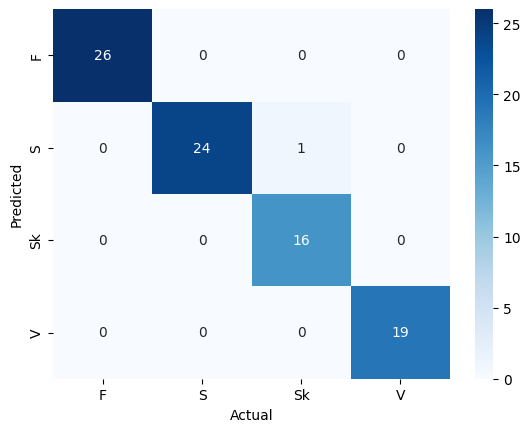

In [25]:
conf_matrix = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d',
            cmap='Blues',
            xticklabels=train_dataset.dataset.classes,
            yticklabels=train_dataset.dataset.classes)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.savefig(Path(results_path)/'train/confusion_matrix_cnn.png')

In [26]:
torch.save(model, Path(results_path)/'models/model_cnn.pth')